In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.signal import argrelextrema
from tqdm import tqdm
from scipy.special import factorial

# Set rcParams to customize tick labels and spines
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['axes.titlesize'] = 12

In [2]:
# source_directory = f"D:/Courses/Uclouvain/thesis/code/these_Colin/seismogram_curve_extraction/data/ground_truths/overlap_20_images/"
source_directory = f"D:/Courses/Uclouvain/thesis/code/these_Colin/seismogram_curve_extraction/results/sBE_UCC__HHE_2024-01-01T00-06-00_2024-01-14T00-12-00_1000_1_0-1_50_50_50_50_0-5_bw_0-1_864-0/"

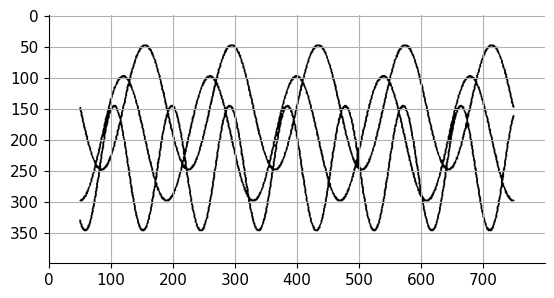

In [3]:
def load_images_from_folder(folder, N_show):
    # set N_show to 0 not to show any images
    saved_images = []  # List to store images
    count = 0
    for image_file in os.listdir(folder):
        if image_file.endswith('_binary.jpg'):
            image_file = os.path.join(folder, image_file)
            saved_images.append(cv2.imread(image_file, cv2.IMREAD_GRAYSCALE))
            if count < N_show:
                plt.imshow(cv2.imread(image_file, cv2.IMREAD_GRAYSCALE), cmap='gray')
                plt.show()
                count += 1

    return np.array(saved_images)

saved_images = load_images_from_folder(source_directory, 3)


In [4]:
# Get the ROI of the images
def get_roi(image):
    temp_image = - (image - np.max(image))
    # Get the row and column indices of the non-zero elements
    rows, cols = np.nonzero(temp_image)
    # Get the minimum and maximum row and column indices
    min_row, max_row = np.min(rows), np.max(rows)
    min_col, max_col = np.min(cols), np.max(cols)
    # Get the ROI of the image
    roi = image[min_row:max_row + 1, min_col:max_col + 1]
    return roi

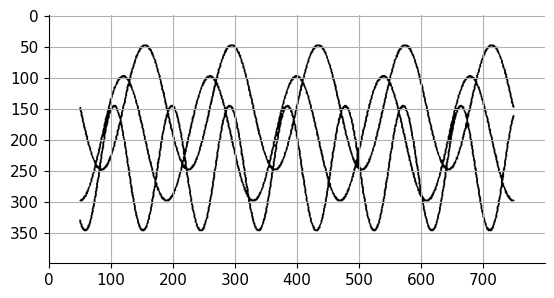

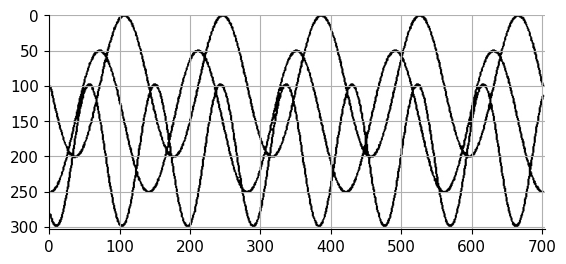

In [5]:
plt.imshow(saved_images[0], cmap='gray')
plt.show()

# Get the ROI of all the images
new_saved_images = []
for image in saved_images:
    new_saved_images.append(np.array(get_roi(image)))

saved_images = new_saved_images

plt.imshow(saved_images[0], cmap='gray')
plt.show()

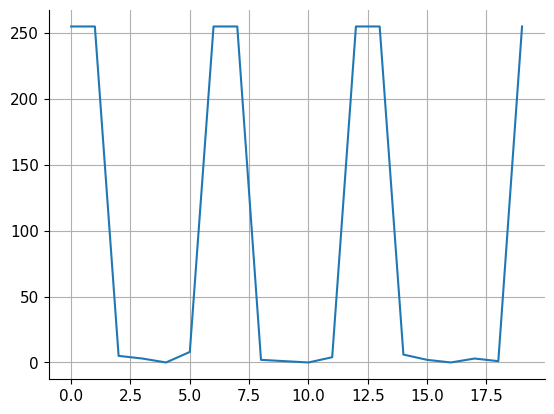

Number of connected components: 3
Average thickness: 4.333333333333333


In [6]:
def count_components_and_avg_thickness(arr, threshold=10):
    """
    Counts the number of connected components where values are close to 0 
    and computes the average thickness.

    Parameters:
    - arr: 1D numpy array containing grayscale values (0 to 255).
    - threshold: Defines what is considered "close to 0" (default: 10).

    Returns:
    - count: Number of connected components.
    - avg_thickness: Average thickness of components.
    """
    count = 0
    thicknesses = []
    n = len(arr)
    
    i = 0
    while i < n:
        if arr[i] < threshold:  # Found a new component (close to 0)
            count += 1
            start = i
            while i < n and arr[i] < threshold:  # Continue until background (255)
                i += 1
            thicknesses.append(i - start)
        else:
            i += 1

    avg_thickness = np.mean(thicknesses) if thicknesses else 0
    return count, avg_thickness

# Example usage
binary_array = np.array([255, 255, 5, 3, 0, 8, 255, 255, 2, 1, 0, 4, 255, 255, 6, 2, 0, 3, 1, 255])
num_components, avg_thickness = count_components_and_avg_thickness(binary_array)

plt.plot(binary_array)
plt.show()

print(f"Number of connected components: {num_components}")
print(f"Average thickness: {avg_thickness}")


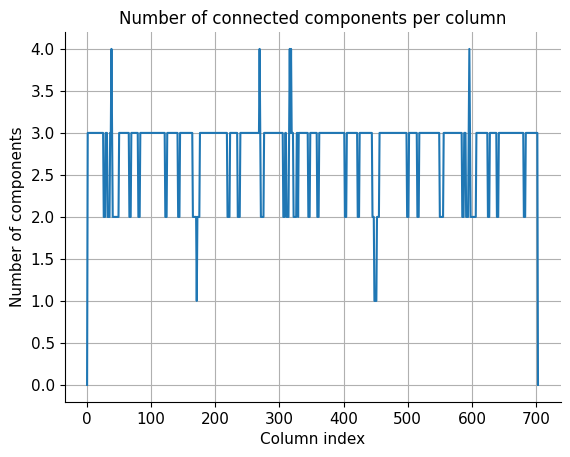

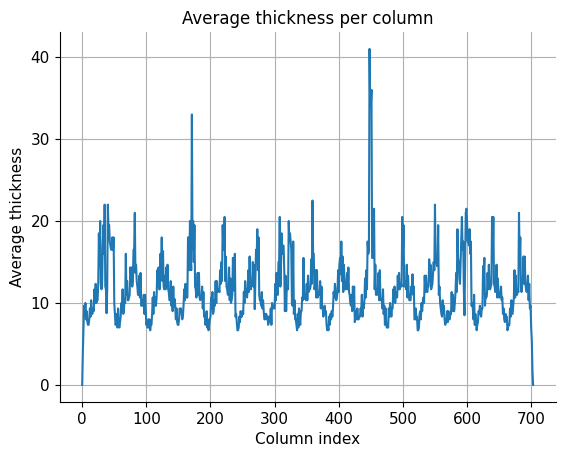

Average number of components: 3 VS true value is 5
Average thickness: 12 VS true value is 15


In [7]:
# apply to the columns of the image and compute the average thickness, average number of components
N_components = []
thickness = []

for i in range(saved_images[0].shape[1]):
    n, t = count_components_and_avg_thickness(saved_images[0][:, i])
    N_components.append(n)
    thickness.append(t)

plt.plot(N_components)
plt.title("Number of connected components per column")
plt.xlabel("Column index")
plt.ylabel("Number of components")
plt.show()

plt.plot(thickness)
plt.title("Average thickness per column")
plt.xlabel("Column index")
plt.ylabel("Average thickness")
plt.show()

# compute the average thickness and number of components for all images by ignoring the columns with no components
N_components = np.array(N_components)
thickness = np.array(thickness)
N_components = N_components[N_components > 1e-6]
thickness = thickness[thickness > 1e-6]

avg_N_components = int(np.round(np.mean(N_components)))
avg_thickness = int(np.round(np.mean(thickness)))
print(f"Average number of components: {avg_N_components} VS true value is 5")
print(f"Average thickness: {avg_thickness} VS true value is 15")


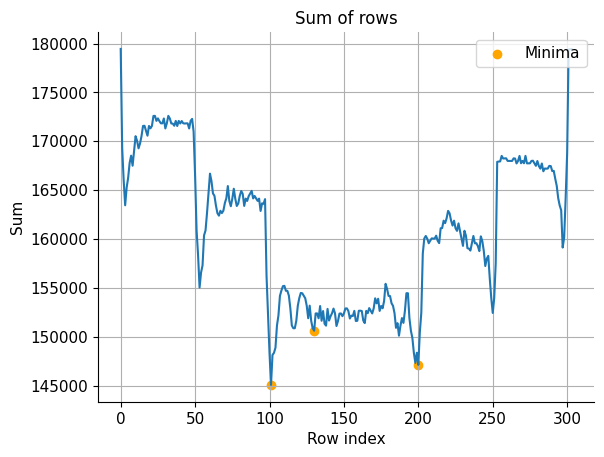

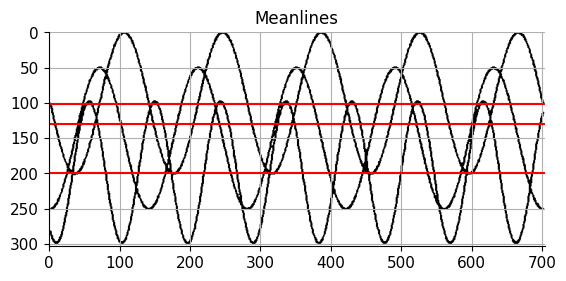

In [8]:
# find the meanlines of each curves in the image
# sum the rows of the image
sum_rows = np.sum(saved_images[0], axis=1)

# Find local minima
min_indices = argrelextrema(sum_rows, np.less, order=10)[0]
sorted_minima = min_indices[np.argsort(sum_rows[min_indices])]

plt.plot(sum_rows)
plt.scatter(sorted_minima[:avg_N_components], sum_rows[sorted_minima[:avg_N_components]], color='orange', label="Minima")
plt.legend()
plt.title("Sum of rows")
plt.xlabel("Row index")
plt.ylabel("Sum")
plt.show()

# The meanlines are the num_components rows with the minimum sum
meanlines = sorted_minima[:avg_N_components]

plt.imshow(saved_images[0], cmap='gray')
for meanline in meanlines:
    plt.axhline(meanline, color='r')
plt.title("Meanlines")
plt.show()

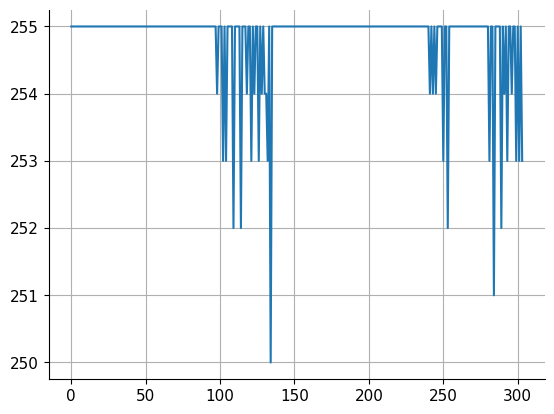

In [9]:
# plot one column of the image
plt.plot(saved_images[0][:, 0])
plt.show()

In [10]:
# Instead use the first column pixels to find the starting points of the N_components curves : X_0 for KF
# Also find the std of the standard deviation of the pixels in the first column to initialize P_0 for KF
X_0 = [100, 250, 280]
P_0 = [0, 0, 0]

# TODO


In [11]:
# Implement the Kalman Filter to track the curves around the meanlines

# Define the prediction step
def predict(X, P, A, Q):
    # check if X has 1 or 2 dimension(s)
    if len(X.shape) == 1:
        X = A @ X
        P = A @ P @ A.T + Q
    else:
        for i in range(X.shape[0]):
            X[i] = A @ X[i]
            P[i] = A @ P[i] @ A.T + Q
        # X = (A @ X.T).T  # Batch multiply all rows of X at once
        # P = A @ P @ A.T + Q  # Assuming P is (N, M, M), use batch multiplication
    return X, P

def  weighted_update(X, P, Z, H, R, P_fp=0):
    """
    Perform the Kalman filter update step using the JPDA approach for multiple traces.

    Args:
        X (np.ndarray): Shape (N, n, 1) - Predicted state estimates for N traces.
        P (np.ndarray): Shape (N, n, n) - Predicted covariance matrices for N traces.
        Z (np.ndarray): Shape (M, m, 1) - Measurements for M detections.
        H (np.ndarray): Shape (m, n) - Observation matrix.
        R (np.ndarray): Shape (m, m) - Measurement noise covariance.

    Returns:
        X_updated (np.ndarray): Shape (N, n, 1) - Updated state estimates.
        P_updated (np.ndarray): Shape (N, n, n) - Updated covariance matrices.
    """
    # print("X shape", X.shape)
    # print("P shape", P.shape)
    # print("Z shape", Z.shape)
    # print("H shape", H.shape)
    # print("R shape", R.shape)
    N, n = X.shape  # Number of traces, state dimension
    M = Z.shape[0]      # Number of measurements
    if N != M : print('merede')
    # m = Z.shape[1]      # Measurement dimension
    m = 1
    
    X_updated = np.copy(X)
    P_updated = np.copy(P)
    
    # Compute innovation covariance and Kalman gains
    S = np.zeros((N, m, m))  # Innovation covariance for each trace
    K = np.zeros((N, n, m))  # Kalman gain for each trace
    for i in range(N):
        S[i] = H @ P[i] @ H.T + R  # Innovation covariance
        if (S[i]).shape[0] == (S[i]).shape[1] == 1: K[i] = (P[i] @ H.T) / S[i]
        else: K[i] = np.linalg.solve(S[i], P[i] @ H.T)  
        # K[i] = P[i] @ H.T @ np.linalg.inv(S[i])  # Kalman gain
    # print("K shape", K.shape)
    # print("S shape", S.shape)

    # Compute association probabilities β_ij using Mahalanobis distance
    beta = np.zeros((N, M))
    likelihoods = np.zeros((N, M))

    for i in range(N):
        for j in range(M):
            residual = Z[j] - H @ X[i]  # Innovation (measurement residual)
            mahalanobis_dist = residual.T @ np.linalg.inv(S[i]) @ residual  # Mahalanobis distance
            likelihoods[i, j] = np.exp(-0.5 * mahalanobis_dist) / np.sqrt((2*np.pi)**m*np.linalg.det(S[i])**2) # USER

    # Normalize probabilities
    for i in range(N):
        beta[i, :] = likelihoods[i, :] / (np.sum(likelihoods[i, :]) + P_fp)  # Avoid division by zero
    # print(beta.sum(axis=1), beta.shape)

    # Update states using weighted innovation
    # print("N",N)
    print("K", K)
    print("-------------------")
    print("b", np.sum(beta, axis=1))
    print("-------------------")
    for i in range(N):
        # print(i)
        weighted_innovation = np.zeros((m, 1))
        for j in range(M):
            weighted_innovation += beta[i, j] * (Z[j] - H @ X[i])
        print("weighted_innovation", weighted_innovation)
        print("-------------------")
        # Update state and covariance
        beta_i = np.sum(beta[i, :])
        # print(X[i])
        # print(K[i], "K", K.shape)
        # print(weighted_innovation)
        # print("tt", "K", K[i].shape, "weighted_innovation", weighted_innovation.shape, (K[i] @ weighted_innovation).shape)
        X_updated[i] = X[i] + (K[i] @ weighted_innovation).ravel()
        temp = (np.eye(n) - beta_i * K[i] @ H)
        P_updated[i] = temp @ P[i] @ temp.T + K[i] @ (np.sum(beta[i, :]**2) * R) @ K[i].T
    # print("X_updated shape", X_updated.shape)
    # print("P_updated shape", P_updated.shape)


    return X_updated, P_updated, beta

In [12]:
# Define the state transition matrix

def state_transition_matrix(degree, Delta):
    """
    Generates the state transition matrix A for a given system degree.
    
    Parameters:
        degree (int): The number of state variables (e.g., 3 for acceleration, 5 for snap).
        Delta (float): Time step.
    
    Returns:
        np.array: State transition matrix of shape (degree, degree).
    """
    A = np.zeros((degree, degree))
    for i in range(degree):
        for j in range(i + 1):
            A[j,i] = (Delta ** (i - j)) / factorial(i - j)
    
    return A

Delta = 1 # Time step [pixels] USER
degree = 5 # USER

# A = np.array([[1, Delta, Delta**2/2],
#               [0, 1, Delta],
#               [0, 0, 1]]) 
A = state_transition_matrix(degree, Delta)
print(A)  

H = np.zeros((1, degree))
H[0, 0] = 1  # Only measure the position

# Define the process noise covariance matrix
sigma_a = 0.1  # Acceleration noise standard deviation
sigma_j = 0.01  # Jerk noise standard deviation

Q = np.zeros((degree, degree))
Q[2, 2] = sigma_a**2  # Process noise in acceleration
Q[3, 3] = sigma_j**2  # Process noise in jerk
# Q = np.eye(degree) * 0.001

# Define the measurement noise covariance matrix
sigma_z = 0.7
R = np.array([[sigma_z**2]])

# Initialize the state and covariance
X = np.zeros((avg_N_components, degree))  # State: [position, velocity, acceleration, jerk, snap]
X[:, 0] = X_0  # Initial position

P = np.zeros((avg_N_components, degree, degree))  # State covariance matrix
P[:, 0, 0] = 0  # Position variance
P[:, 1, 1] = 1  # Velocity variance
P[:, 2, 2] = 1  # Acceleration variance
P[:, 3, 3] = 1  # Jerk variance (new)
P[:, 4, 4] = 1  # Snap variance (new)

[[1.         1.         0.5        0.16666667 0.04166667]
 [0.         1.         1.         0.5        0.16666667]
 [0.         0.         1.         1.         0.5       ]
 [0.         0.         0.         1.         1.        ]
 [0.         0.         0.         0.         1.        ]]


In [13]:
sel = 0 # selected image


In [14]:
# Now we can apply the Kalman filter to track the curves around the meanlines

# Initialize the list of estimated positions
estimated_positions_weighted = [[X[i, 0]] for i in range(avg_N_components)]

In [15]:
### 
# Weighted Kalman filter
###
X_weighted = np.copy(X)
P_weighted = np.copy(P)
tresh = 1e-2

for k in tqdm(range(1, saved_images[sel].shape[1]), desc="Processing columns"):

    col = saved_images[sel][:, k].astype(np.float64)
    if col.max() - col.min() > 0: col /= col.max() - col.min()
    # find the 0 value pixels, with a given treshold
    measurements = np.where(col < tresh)[0]

    # Predict
    X_w, P_w = predict(X_weighted, P_weighted, A, Q)
    # Weighted Update
    X_weighted, P_weighted, beta = weighted_update(X_w, P_w, measurements, H, R)
    # print(X_weighted)
    for i in range(avg_N_components):
        # Save the estimated position
        estimated_positions_weighted[i].append(X_weighted[i, 0])

Processing columns:   0%|          | 0/703 [00:00<?, ?it/s]

merede
K [[[0.72308779]
  [0.89870884]
  [0.38852478]
  [0.11773478]
  [0.02354696]]

 [[0.72308779]
  [0.89870884]
  [0.38852478]
  [0.11773478]
  [0.02354696]]

 [[0.72308779]
  [0.89870884]
  [0.38852478]
  [0.11773478]
  [0.02354696]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[2.20211042]]
-------------------
weighted_innovation [[1.]]
-------------------
weighted_innovation [[2.24373313]]
-------------------
merede
K [[[0.88388702]
  [1.13427782]
  [0.98889848]
  [0.51352536]
  [0.13824585]]

 [[0.89674584]
  [1.09006491]
  [0.91061936]
  [0.46517425]
  [0.12435574]]

 [[0.88241066]
  [1.13935404]
  [0.99788594]
  [0.5190767 ]
  [0.13984062]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[0.16595191]]
-------------------
weighted_innovation [[-0.72386625]]
-------------------
weighted_innovation [[0.710704]]
-------------------
merede
K [[[0.9279116 ]
  [1.46967946]
  [1.4350035 ]
  [0.83185924]
  [0.22781105]]

 [[0.93

Processing columns:   4%|▎         | 26/703 [00:00<00:02, 257.32it/s]

merede
K [[[0.64849062]
  [0.55259821]
  [0.25914364]
  [0.06247529]
  [0.00661903]]

 [[0.7404982 ]
  [0.53694205]
  [0.23827475]
  [0.05663927]
  [0.00599009]]

 [[0.7653243 ]
  [0.56957998]
  [0.25130332]
  [0.05945535]
  [0.0062622 ]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[-0.05414603]]
-------------------
weighted_innovation [[6.30203653]]
-------------------
weighted_innovation [[-0.82107768]]
-------------------
merede
K [[[0.65363188]
  [0.52372609]
  [0.23286947]
  [0.05227439]
  [0.00511917]]

 [[0.74912919]
  [0.51002118]
  [0.21506682]
  [0.04768737]
  [0.00466874]]

 [[0.66057392]
  [0.52833266]
  [0.23552056]
  [0.05317106]
  [0.00523929]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[-11.30927509]]
-------------------
weighted_innovation [[5.28755778]]
-------------------
weighted_innovation [[-0.36927282]]
-------------------
merede
K [[[0.74692238]
  [0.51498684]
  [0.20944396]
  [0.04340554]
  [0.00392

Processing columns:   7%|▋         | 52/703 [00:00<00:02, 232.36it/s]

merede
K [[[6.82485925e-01]
  [3.79895816e-01]
  [1.20401589e-01]
  [1.18838844e-02]
  [3.07872481e-04]]

 [[6.75844435e-01]
  [3.85165059e-01]
  [1.23730122e-01]
  [1.22670061e-02]
  [3.18939420e-04]]

 [[6.36068281e-01]
  [3.77276177e-01]
  [1.24512774e-01]
  [1.24269295e-02]
  [3.22386823e-04]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[-13.49687162]]
-------------------
weighted_innovation [[0.0159916]]
-------------------
weighted_innovation [[3.88510862]]
-------------------
merede
K [[[6.82657938e-01]
  [3.85224864e-01]
  [1.22759740e-01]
  [1.20385047e-02]
  [3.04488780e-04]]

 [[5.48062174e-01]
  [3.65211950e-01]
  [1.27153991e-01]
  [1.27688004e-02]
  [3.24255502e-04]]

 [[6.67974375e-01]
  [3.87732751e-01]
  [1.25224802e-01]
  [1.23253720e-02]
  [3.12107220e-04]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[-1.28719169]]
-------------------
weighted_innovation [[-0.26288476]]
-------------------
weighted_innovat

Processing columns:  11%|█         | 76/703 [00:00<00:03, 187.41it/s]

merede
K [[[6.87967445e-01]
  [3.90621769e-01]
  [1.20920909e-01]
  [1.09977099e-02]
  [2.19592490e-04]]

 [[6.81132108e-01]
  [3.80544820e-01]
  [1.18256130e-01]
  [1.07851721e-02]
  [2.15953375e-04]]

 [[5.56857539e-01]
  [3.54223184e-01]
  [1.20443843e-01]
  [1.12559840e-02]
  [2.24994821e-04]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[-8.98445644]]
-------------------
weighted_innovation [[5.97629523]]
-------------------
weighted_innovation [[1.71073356]]
-------------------
merede
K [[[6.82767809e-01]
  [3.78884647e-01]
  [1.17247892e-01]
  [1.06239899e-02]
  [2.08084797e-04]]

 [[6.78312471e-01]
  [3.82367894e-01]
  [1.19613646e-01]
  [1.08780687e-02]
  [2.13652755e-04]]

 [[6.28503724e-01]
  [3.76134420e-01]
  [1.23197347e-01]
  [1.13464310e-02]
  [2.22453131e-04]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[-6.81338014]]
-------------------
weighted_innovation [[1.34160358]]
-------------------
weighted_innovati

Processing columns:  17%|█▋        | 118/703 [00:00<00:03, 189.19it/s]

merede
K [[[5.54889744e-01]
  [3.57715377e-01]
  [1.19396993e-01]
  [1.00675009e-02]
  [1.18784899e-04]]

 [[5.54745909e-01]
  [3.62332548e-01]
  [1.21066086e-01]
  [1.02084902e-02]
  [1.20652777e-04]]

 [[6.78720475e-01]
  [3.76949372e-01]
  [1.14918126e-01]
  [9.45272365e-03]
  [1.11589480e-04]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[-0.01400122]]
-------------------
weighted_innovation [[-0.15050586]]
-------------------
weighted_innovation [[11.39608456]]
-------------------
merede
K [[[5.55729517e-01]
  [3.55663252e-01]
  [1.18663150e-01]
  [9.99208662e-03]
  [1.16522307e-04]]

 [[5.67319379e-01]
  [3.65951738e-01]
  [1.21071117e-01]
  [1.01657712e-02]
  [1.18746471e-04]]

 [[6.76083470e-01]
  [3.70314274e-01]
  [1.13303838e-01]
  [9.32244806e-03]
  [1.08769550e-04]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[0.00162375]]
-------------------
weighted_innovation [[-4.88622262]]
-------------------
weighted_innova

Processing columns:  23%|██▎       | 162/703 [00:00<00:02, 194.67it/s]

merede
K [[[6.66835965e-01]
  [3.69149922e-01]
  [1.12986347e-01]
  [8.94992984e-03]
  [7.41274102e-05]]

 [[6.65506623e-01]
  [3.78869735e-01]
  [1.17272996e-01]
  [9.31509575e-03]
  [7.72438616e-05]]

 [[6.71802002e-01]
  [3.69681807e-01]
  [1.13480680e-01]
  [8.99908133e-03]
  [7.45622412e-05]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[1.22230782]]
-------------------
weighted_innovation [[-9.05809851]]
-------------------
weighted_innovation [[2.57819077]]
-------------------
merede
K [[[6.01508715e-01]
  [3.61450118e-01]
  [1.16193310e-01]
  [9.32157753e-03]
  [7.65714146e-05]]

 [[6.74412775e-01]
  [3.70482240e-01]
  [1.12975036e-01]
  [8.93360849e-03]
  [7.34712310e-05]]

 [[6.43347135e-01]
  [3.67391897e-01]
  [1.14818352e-01]
  [9.14147428e-03]
  [7.51196788e-05]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[0.5671877]]
-------------------
weighted_innovation [[-8.95183854]]
-------------------
weighted_innovatio

Processing columns:  29%|██▊       | 202/703 [00:01<00:02, 188.22it/s]


K [[[5.90553675e-01]
  [3.46796835e-01]
  [1.11253602e-01]
  [8.72098495e-03]
  [5.26196080e-05]]

 [[5.56003979e-01]
  [3.52185483e-01]
  [1.15720703e-01]
  [9.11884908e-03]
  [5.50679635e-05]]

 [[5.54208797e-01]
  [3.51409565e-01]
  [1.15747728e-01]
  [9.12774407e-03]
  [5.50887903e-05]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[5.35360521]]
-------------------
weighted_innovation [[5.47319192e-08]]
-------------------
weighted_innovation [[11.41860839]]
-------------------
merede
K [[[6.55121361e-01]
  [3.71664429e-01]
  [1.15950387e-01]
  [9.01045832e-03]
  [5.40401363e-05]]

 [[5.50658778e-01]
  [3.48961759e-01]
  [1.15539838e-01]
  [9.12372687e-03]
  [5.47666890e-05]]

 [[6.54234970e-01]
  [3.77915456e-01]
  [1.17723143e-01]
  [9.13805959e-03]
  [5.48201909e-05]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[0.16921967]]
-------------------
weighted_innovation [[0.16511527]]
-------------------
weighted_innovation 

Processing columns:  34%|███▍      | 241/703 [00:01<00:02, 169.79it/s]

merede
K [[[5.62916054e-01]
  [3.48992455e-01]
  [1.15566853e-01]
  [9.02328472e-03]
  [4.40726941e-05]]

 [[6.62321570e-01]
  [3.71329413e-01]
  [1.14161767e-01]
  [8.72771670e-03]
  [4.26590001e-05]]

 [[5.49353598e-01]
  [3.45123881e-01]
  [1.14059210e-01]
  [8.89829564e-03]
  [4.34717429e-05]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[-1.4555387]]
-------------------
weighted_innovation [[2.18725233]]
-------------------
weighted_innovation [[-0.00012547]]
-------------------
merede
K [[[6.15673838e-01]
  [3.63353393e-01]
  [1.16185064e-01]
  [8.98112554e-03]
  [4.36535564e-05]]

 [[6.35882403e-01]
  [3.59529695e-01]
  [1.12052928e-01]
  [8.60181360e-03]
  [4.18391161e-05]]

 [[5.46076407e-01]
  [3.42411631e-01]
  [1.14107991e-01]
  [8.92341615e-03]
  [4.33825257e-05]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[-7.26085296]]
-------------------
weighted_innovation [[1.13930296]]
-------------------
weighted_innovati

Processing columns:  43%|████▎     | 304/703 [00:01<00:02, 193.99it/s]

K [[[6.54718934e-01]
  [3.71276259e-01]
  [1.15134964e-01]
  [8.74402926e-03]
  [3.51537985e-05]]

 [[6.68845518e-01]
  [3.66520477e-01]
  [1.11737345e-01]
  [8.44711252e-03]
  [3.39797394e-05]]

 [[5.57330130e-01]
  [3.60737660e-01]
  [1.18718484e-01]
  [9.15380466e-03]
  [3.68078732e-05]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[0.02394257]]
-------------------
weighted_innovation [[-0.903078]]
-------------------
weighted_innovation [[0.19405612]]
-------------------
merede
K [[[5.36679069e-01]
  [3.39006455e-01]
  [1.12768501e-01]
  [8.73258316e-03]
  [3.49672021e-05]]

 [[5.82162439e-01]
  [3.52254482e-01]
  [1.13910797e-01]
  [8.75122133e-03]
  [3.50620193e-05]]

 [[5.68188356e-01]
  [3.57966869e-01]
  [1.16400798e-01]
  [8.94789049e-03]
  [3.58357855e-05]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[-0.16872954]]
-------------------
weighted_innovation [[-0.08924566]]
-------------------
weighted_innovation [[0.0

Processing columns:  46%|████▌     | 324/703 [00:01<00:02, 187.19it/s]

merede
K [[[5.53112661e-01]
  [3.50661939e-01]
  [1.15407993e-01]
  [8.85080924e-03]
  [3.02347411e-05]]

 [[6.47515116e-01]
  [3.63723841e-01]
  [1.12737542e-01]
  [8.51044303e-03]
  [2.90863213e-05]]

 [[6.56815434e-01]
  [3.64701207e-01]
  [1.12276981e-01]
  [8.45914263e-03]
  [2.89012256e-05]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[-0.25870121]]
-------------------
weighted_innovation [[3.40759668]]
-------------------
weighted_innovation [[4.45132328]]
-------------------
merede
K [[[5.61876202e-01]
  [3.48721056e-01]
  [1.14247950e-01]
  [8.75445907e-03]
  [2.98037937e-05]]

 [[6.54831006e-01]
  [3.68602933e-01]
  [1.13595070e-01]
  [8.55622572e-03]
  [2.91431905e-05]]

 [[6.62848930e-01]
  [3.68627846e-01]
  [1.12934106e-01]
  [8.49248254e-03]
  [2.89163390e-05]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[0.05283267]]
-------------------
weighted_innovation [[0.03529377]]
-------------------
weighted_innovatio

Processing columns:  52%|█████▏    | 368/703 [00:01<00:01, 193.41it/s]

K [[[6.70846446e-01]
  [3.68581116e-01]
  [1.10964931e-01]
  [8.26622774e-03]
  [2.49934018e-05]]

 [[6.09220627e-01]
  [3.72790027e-01]
  [1.18161348e-01]
  [8.92271246e-03]
  [2.69900532e-05]]

 [[6.47487286e-01]
  [3.80522845e-01]
  [1.18067704e-01]
  [8.86401375e-03]
  [2.68044814e-05]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[5.74906617]]
-------------------
weighted_innovation [[-9.1410663]]
-------------------
weighted_innovation [[-2.47676097]]
-------------------
merede
K [[[6.68368847e-01]
  [3.66144632e-01]
  [1.10954860e-01]
  [8.28417566e-03]
  [2.49721636e-05]]

 [[6.70541515e-01]
  [3.84152439e-01]
  [1.16711783e-01]
  [8.70572001e-03]
  [2.62542633e-05]]

 [[6.43295291e-01]
  [3.63209493e-01]
  [1.11680013e-01]
  [8.37127057e-03]
  [2.52381232e-05]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[1.65810704]]
-------------------
weighted_innovation [[-9.49058687]]
-------------------
weighted_innovation [[3.

Processing columns:  63%|██████▎   | 442/703 [00:02<00:01, 219.88it/s]

merede
K [[[5.81408299e-01]
  [3.49391921e-01]
  [1.13083752e-01]
  [8.57163542e-03]
  [2.26321933e-05]]

 [[5.46513092e-01]
  [3.42159692e-01]
  [1.12578428e-01]
  [8.56875383e-03]
  [2.26331770e-05]]

 [[6.19451901e-01]
  [3.74683351e-01]
  [1.18748170e-01]
  [8.93390981e-03]
  [2.35915255e-05]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[2.13919723]]
-------------------
weighted_innovation [[-2.49537106]]
-------------------
weighted_innovation [[-0.03738614]]
-------------------
merede
K [[[6.32915228e-01]
  [3.64877255e-01]
  [1.14798763e-01]
  [8.63093089e-03]
  [2.27287426e-05]]

 [[6.49287949e-01]
  [3.74979038e-01]
  [1.16986808e-01]
  [8.77062574e-03]
  [2.31053641e-05]]

 [[5.46485436e-01]
  [3.43947317e-01]
  [1.12880694e-01]
  [8.58098287e-03]
  [2.25998823e-05]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[3.26781951]]
-------------------
weighted_innovation [[-5.04364318]]
-------------------
weighted_innovat

Processing columns:  69%|██████▉   | 488/703 [00:02<00:01, 212.18it/s]

merede
K [[[5.82426288e-01]
  [3.53058528e-01]
  [1.14401414e-01]
  [8.64416783e-03]
  [2.00683477e-05]]

 [[5.52073588e-01]
  [3.49420660e-01]
  [1.14734482e-01]
  [8.69447104e-03]
  [2.01918718e-05]]

 [[6.70278812e-01]
  [3.66240189e-01]
  [1.11068502e-01]
  [8.23668979e-03]
  [1.91243386e-05]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[-0.78332601]]
-------------------
weighted_innovation [[-0.30698168]]
-------------------
weighted_innovation [[1.16191683]]
-------------------
merede
K [[[5.83860055e-01]
  [3.49120602e-01]
  [1.12915487e-01]
  [8.52992016e-03]
  [1.97572411e-05]]

 [[5.64122323e-01]
  [3.47919732e-01]
  [1.13592208e-01]
  [8.59936219e-03]
  [1.99247201e-05]]

 [[5.95419595e-01]
  [3.56153989e-01]
  [1.13832036e-01]
  [8.56368351e-03]
  [1.98375085e-05]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[-4.5379865]]
-------------------
weighted_innovation [[1.63246076]]
-------------------
weighted_innovati

Processing columns:  76%|███████▌  | 534/703 [00:02<00:00, 216.75it/s]

merede
K [[[6.56468715e-01]
  [3.77333135e-01]
  [1.15510431e-01]
  [8.55746220e-03]
  [1.79500919e-05]]

 [[5.61125066e-01]
  [3.53143486e-01]
  [1.14706234e-01]
  [8.64228758e-03]
  [1.81334901e-05]]

 [[6.58961406e-01]
  [3.69042092e-01]
  [1.13429328e-01]
  [8.42304175e-03]
  [1.76697970e-05]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[-3.27480284]]
-------------------
weighted_innovation [[0.42664439]]
-------------------
weighted_innovation [[1.51983163]]
-------------------
merede
K [[[6.55101326e-01]
  [3.65472041e-01]
  [1.11141143e-01]
  [8.22518138e-03]
  [1.72169870e-05]]

 [[5.74563030e-01]
  [3.59919689e-01]
  [1.16456200e-01]
  [8.76428928e-03]
  [1.83509729e-05]]

 [[6.13593777e-01]
  [3.60059075e-01]
  [1.13401139e-01]
  [8.47673606e-03]
  [1.77452107e-05]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[-3.369045]]
-------------------
weighted_innovation [[2.84400306]]
-------------------
weighted_innovation

Processing columns:  79%|███████▉  | 556/703 [00:02<00:00, 179.24it/s]

merede
K [[[5.57000951e-01]
  [3.60315468e-01]
  [1.18005041e-01]
  [8.88975426e-03]
  [1.70061895e-05]]

 [[5.56557746e-01]
  [3.49853011e-01]
  [1.13814571e-01]
  [8.56353250e-03]
  [1.63866311e-05]]

 [[5.48613353e-01]
  [3.45850428e-01]
  [1.14151392e-01]
  [8.62855350e-03]
  [1.65079282e-05]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[-0.02114756]]
-------------------
weighted_innovation [[0.00017264]]
-------------------
weighted_innovation [[-0.22024735]]
-------------------
merede
K [[[5.55034662e-01]
  [3.52461416e-01]
  [1.15033523e-01]
  [8.66239593e-03]
  [1.65396103e-05]]

 [[5.52370394e-01]
  [3.52787778e-01]
  [1.15747642e-01]
  [8.72911877e-03]
  [1.66715847e-05]]

 [[5.60601431e-01]
  [3.47408038e-01]
  [1.14083798e-01]
  [8.61380403e-03]
  [1.64482415e-05]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[-2.1430413]]
-------------------
weighted_innovation [[1.25085337]]
-------------------
weighted_innovati

Processing columns:  85%|████████▌ | 600/703 [00:03<00:00, 187.17it/s]

merede
K [[[6.17094498e-01]
  [3.69556673e-01]
  [1.16275170e-01]
  [8.65729549e-03]
  [1.56626115e-05]]

 [[5.74178974e-01]
  [3.56198152e-01]
  [1.14575322e-01]
  [8.58309482e-03]
  [1.55324094e-05]]

 [[6.66099194e-01]
  [3.66012370e-01]
  [1.11032294e-01]
  [8.19061860e-03]
  [1.48195129e-05]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[-2.40120438]]
-------------------
weighted_innovation [[0.00209245]]
-------------------
weighted_innovation [[7.98736522]]
-------------------
merede
K [[[6.42688302e-01]
  [3.68309747e-01]
  [1.13470231e-01]
  [8.40171661e-03]
  [1.51727729e-05]]

 [[5.56129449e-01]
  [3.60157055e-01]
  [1.17725422e-01]
  [8.85313502e-03]
  [1.59921478e-05]]

 [[6.69175878e-01]
  [3.64221347e-01]
  [1.10387588e-01]
  [8.14268633e-03]
  [1.47061794e-05]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[-1.4213439]]
-------------------
weighted_innovation [[4.25198183]]
-------------------
weighted_innovatio

Processing columns:  91%|█████████▏| 643/703 [00:03<00:00, 194.92it/s]

K [[[5.98140582e-01]
  [3.63076133e-01]
  [1.15874812e-01]
  [8.65502399e-03]
  [1.46264857e-05]]

 [[6.25394488e-01]
  [3.58373195e-01]
  [1.11620581e-01]
  [8.28568040e-03]
  [1.40057196e-05]]

 [[6.69611729e-01]
  [3.66330637e-01]
  [1.11203988e-01]
  [8.19585922e-03]
  [1.38515754e-05]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[1.16415764]]
-------------------
weighted_innovation [[-1.22846241]]
-------------------
weighted_innovation [[4.62354971]]
-------------------
merede
K [[[6.54664707e-01]
  [3.71173741e-01]
  [1.14016533e-01]
  [8.42663953e-03]
  [1.42165042e-05]]

 [[6.06066046e-01]
  [3.62574538e-01]
  [1.15136453e-01]
  [8.58790767e-03]
  [1.44920935e-05]]

 [[6.61949879e-01]
  [3.61347207e-01]
  [1.09941808e-01]
  [8.11045027e-03]
  [1.36841012e-05]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[3.92120044]]
-------------------
weighted_innovation [[-1.10944392]]
-------------------
weighted_innovation [[3.

Processing columns:  98%|█████████▊| 689/703 [00:03<00:00, 210.86it/s]

merede
K [[[6.72931020e-01]
  [3.72147124e-01]
  [1.12330567e-01]
  [8.24866463e-03]
  [1.29545989e-05]]

 [[5.49126606e-01]
  [3.52995958e-01]
  [1.15857110e-01]
  [8.70535368e-03]
  [1.36749208e-05]]

 [[5.50722718e-01]
  [3.48662972e-01]
  [1.14536736e-01]
  [8.61450459e-03]
  [1.35301080e-05]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[-1.87824155]]
-------------------
weighted_innovation [[0.3017695]]
-------------------
weighted_innovation [[8.3836133]]
-------------------
merede
K [[[6.27225638e-01]
  [3.66521820e-01]
  [1.13981838e-01]
  [8.43858357e-03]
  [1.32320871e-05]]

 [[5.73841308e-01]
  [3.62679588e-01]
  [1.17336133e-01]
  [8.78019581e-03]
  [1.37708554e-05]]

 [[6.52789691e-01]
  [3.77271423e-01]
  [1.16951996e-01]
  [8.65347965e-03]
  [1.35700097e-05]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[0.00101145]]
-------------------
weighted_innovation [[-0.47793753]]
-------------------
weighted_innovation

Processing columns: 100%|██████████| 703/703 [00:03<00:00, 195.74it/s]

K [[[6.26890055e-01]
  [3.62906027e-01]
  [1.13927863e-01]
  [8.45637797e-03]
  [1.22959581e-05]]

 [[6.68774500e-01]
  [3.66347184e-01]
  [1.11205975e-01]
  [8.17619071e-03]
  [1.18910390e-05]]

 [[6.69206964e-01]
  [3.67555902e-01]
  [1.11559985e-01]
  [8.20015368e-03]
  [1.19241751e-05]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[4.92132511]]
-------------------
weighted_innovation [[-3.47168277]]
-------------------
weighted_innovation [[4.3413455]]
-------------------
merede
K [[[6.64425432e-01]
  [3.67505796e-01]
  [1.12287697e-01]
  [8.27092254e-03]
  [1.20088361e-05]]

 [[6.52993098e-01]
  [3.60615650e-01]
  [1.10510011e-01]
  [8.14871482e-03]
  [1.18338689e-05]]

 [[6.65406873e-01]
  [3.72816156e-01]
  [1.13471194e-01]
  [8.34085335e-03]
  [1.21111608e-05]]]
-------------------
b [1. 1. 1.]
-------------------
weighted_innovation [[4.8955553]]
-------------------
weighted_innovation [[-17.03984759]]
-------------------
weighted_innovation [[0.7

[[100.0, 101.59231915634689, 104.19121661085507, 107.97621735519651, 112.92824083798007, 119.1751375839653, 125.88071891838109, 132.0283168373947, 135.68620513205502, 135.9252833254672, 132.36322251960797, 134.4400372805793, 138.8498333032505, 144.04982633642197, 150.5374724372893, 161.0573305835426, 169.9169353867684, 174.13189447422644, 175.74774262477422, 178.7040795756203, 179.65558221382778, 181.30867030841466, 182.19725625603354, 182.397491964367, 183.10232485877296, 184.94015279281106, 186.79949244182558, 188.54156151527067, 190.91327074381286, 194.51894725743026, 198.82125091116947, 204.93872209723767, 212.7787643605782, 217.22293723430312, 209.57602749574215, 204.40615616484578, 199.5488988394533, 186.5512808666987, 171.85080777091878, 153.58110293167272, 130.4027139024528, 115.08857808922883, 109.89268148138547, 110.01342764792275, 111.24143236780036, 115.80715680293532, 126.50578279233459, 133.6828875346287, 129.96152854649304, 124.34538152816978, 116.2853316094056, 109.9990

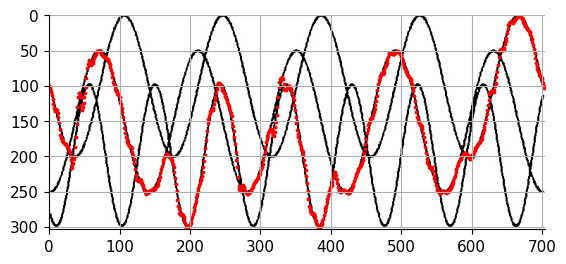

[[100.0, 101.59231915634689, 104.19121661085507, 107.97621735519651, 112.92824083798007, 119.1751375839653, 125.88071891838109, 132.0283168373947, 135.68620513205502, 135.9252833254672, 132.36322251960797, 134.4400372805793, 138.8498333032505, 144.04982633642197, 150.5374724372893, 161.0573305835426, 169.9169353867684, 174.13189447422644, 175.74774262477422, 178.7040795756203, 179.65558221382778, 181.30867030841466, 182.19725625603354, 182.397491964367, 183.10232485877296, 184.94015279281106, 186.79949244182558, 188.54156151527067, 190.91327074381286, 194.51894725743026, 198.82125091116947, 204.93872209723767, 212.7787643605782, 217.22293723430312, 209.57602749574215, 204.40615616484578, 199.5488988394533, 186.5512808666987, 171.85080777091878, 153.58110293167272, 130.4027139024528, 115.08857808922883, 109.89268148138547, 110.01342764792275, 111.24143236780036, 115.80715680293532, 126.50578279233459, 133.6828875346287, 129.96152854649304, 124.34538152816978, 116.2853316094056, 109.9990

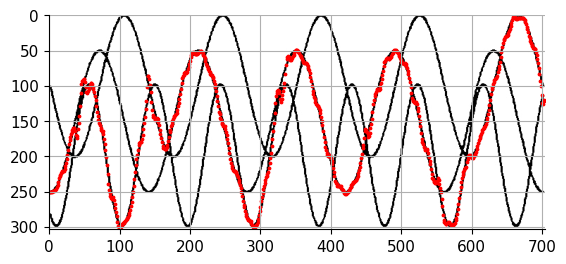

[[100.0, 101.59231915634689, 104.19121661085507, 107.97621735519651, 112.92824083798007, 119.1751375839653, 125.88071891838109, 132.0283168373947, 135.68620513205502, 135.9252833254672, 132.36322251960797, 134.4400372805793, 138.8498333032505, 144.04982633642197, 150.5374724372893, 161.0573305835426, 169.9169353867684, 174.13189447422644, 175.74774262477422, 178.7040795756203, 179.65558221382778, 181.30867030841466, 182.19725625603354, 182.397491964367, 183.10232485877296, 184.94015279281106, 186.79949244182558, 188.54156151527067, 190.91327074381286, 194.51894725743026, 198.82125091116947, 204.93872209723767, 212.7787643605782, 217.22293723430312, 209.57602749574215, 204.40615616484578, 199.5488988394533, 186.5512808666987, 171.85080777091878, 153.58110293167272, 130.4027139024528, 115.08857808922883, 109.89268148138547, 110.01342764792275, 111.24143236780036, 115.80715680293532, 126.50578279233459, 133.6828875346287, 129.96152854649304, 124.34538152816978, 116.2853316094056, 109.9990

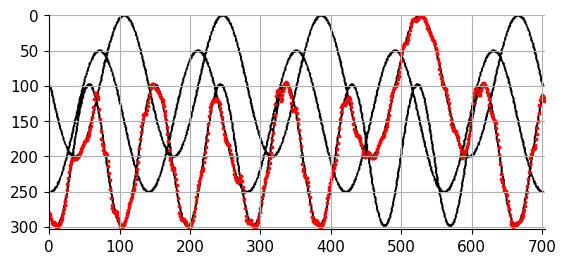

In [16]:
for i in range(avg_N_components):
    estimated_positions = estimated_positions_weighted[i]
    print(estimated_positions_weighted)

    # Plot the estimated positions
    plt.imshow(saved_images[sel], cmap='gray')

    estimated_positions = np.array(estimated_positions)
    print(estimated_positions.shape)

    i = 0
    if True:
        valid_indices = ~np.isnan(estimated_positions)  # Get valid (non-NaN) indices
        plt.scatter(np.where(valid_indices)[0], estimated_positions[valid_indices], color='r', s=3)

    plt.show()


    # comments:
    # better init, X_0 artificially given
    # all the black pixels in a specific column are considered as measurements
    # Problem, find good values for hyperparameters such as std